<font size="5"> <b>Python API Training - SHAP Values</b> </font>

<b>Author:</b> Sara Cooper <br>
<b>Contributors:</b> Cory Kind, Mark Romanowsky

Below is the main documentation source you can consult: <br>
[API Documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.21.1/)

Here is a high level overview of this notebook:

1. Connecting to DataRobot [3min]<br>
2. Creating a SHAP Project [25min]<br>
3. Model Deployment [5min]<br>
4. Model Scoring [5min]<br>
5. Request Shapley Prediction Explanations [10min]<br>
6. Getting SHAP Output Visualizations [5min]<br>

<b>Data</b>

The dataset we will be using throughout these exercises is one from Kaggle about predicting a biological response of molecules from their chemical properties. You can access the Kaggle page with both the training and testing data [here.](https://www.kaggle.com/c/bioresponse/data)

<b>Requirements</b>

 - Python version 3.7.3
 - DataRobot API version 2.20.0.
 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

<font size="4"> <b>Import Libraries</b> </font>

In [1]:
import datarobot as dr
import pandas as pd

<font size="4"> <b>1. Connecting to DataRobot</b> </font>

To use Python with DataRobot you first need to establish a connection between your machine and the DataRobot instance. The fastest and safest way to do that is by creating a <code>.yaml</code> file with your credentials. This is basically a text file containing two lines:

<code>endpoint: "YOUR_HOSTNAME"</code>
<code>token: "YOUR_API_TOKEN"</code>

You can then use the <code>datarobot.Client</code> method to connect to DataRobot like below. If you choose not to use a yaml file, this is an example of the command you would use to connect to DataRobot's managed cloud service. (An on-premise customer would have a different endpoint location).

<code>dr.Client(endpoint='https//:app.datarobot.com/api/v2', token = 'YOUR_API_TOKEN')</code>

In [2]:
dr.Client(config_path="/Desktop/config.yaml")

<font size="4"> <b>2. Creating a SHAP Project</b> </font>

For Classification, Regression and Multiclass Classification, the process of starting a project (and modeling) is very straightforward. In this tutorial we are going to create a project from a file and set the target with advanced options.

In the UI choose “Include only SHAP supported blueprints” in “Advanced Options” at project creation

- SHAP based insights are not accessible without checking this option prior to project start
- SHAP supported models will have a “badge” on the leaderboard and in repository
- Alternative methods, including permutation Feature Impact and XEMP Prediction Explanations are not accessible in SHAP based projects

In [ ]:
project = dr.Project.create("/bio_response_data.csv", 
                            project_name ='Predicting_Bio_Response_Trial') 

project.set_target(target ='Activity', 
                   mode = dr.AUTOPILOT_MODE.FULL_AUTO, 
                   worker_count = -1, 
                   advanced_options = dr.AdvancedOptions(shap_only_mode = True))

project.wait_for_autopilot()

The <code>mode</code> object defines the modeling process. The value autopilot means that the modeling process will proceed completely automatically, including running recommended models, running at different sample sizes, and blending. <br>
The <code>worker_count</code> variable defines how many workers is the project going to use when modeling. The value -1 means use all of the available workers. <br>
The <code>advanced options</code> object is used to set advanced options of the modeling process. The value shap_only_mode = True will run only models that support SHAP values during Autopilot. <br>
The <code>wait_for_autopilot</code> method will force our Python Kernel to wait until DataRobot has finished modeling before executing the next series of commands.

<font size="2"> <b>Get Trained Models</b> </font> <br>
We can use the `get_models` method to retrieve a list of all the trained DataRobot models. We can then choose the model we want from the list and get access to multiple methods for results/specifics.

By default, the models will be ordered based on their validation score. The first model will be the most accurate one.

In [4]:
project.get_models()[0:10]

[Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Gradient Boosted Trees Classifier'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('Gradient Boosted Greedy Trees Classifier'),
 Model('eXtreme Gradient Boosted Trees Classifier'),
 Model('eXtreme Gradient Boosted Trees Classifier')]

In [5]:
#I am going to select the most accurate non-XGB model
#I am also selecting a model without "Feature Selection for dimensionality reduction" in the blueprint
most_accurate_model = project.get_models()[4]

#Get type of model
print(most_accurate_model.model_type)

Light Gradient Boosted Trees Classifier with Early Stopping


<font size="2"> <b>Get Feature Impact</b> </font> <br>
SHAP based Feature Impact works the same as permutation based Feature Impact in that the user interface and API response remains the same
- SHAP based Feature Impact tends to perform well on wide datasets compared to permutation
- All features are calculated and rank-ordered, but only the <code>top 1000</code> are stored

- It can be calculated using DataRobot's <code>ShapImpact</code> method

In [6]:
project_id = project.id
model_id = most_accurate_model.id
shap_impact_job = dr.ShapImpact.create(project_id = project_id, model_id = model_id)
shap_impact = shap_impact_job.get_result_when_complete()
print(shap_impact)
print(shap_impact.shap_impacts[:5])

ShapImpact(count=1000)
[{'feature_name': 'D27', 'impact_normalized': 1.0, 'impact_unnormalized': 0.4964422195731609}, {'feature_name': 'D78', 'impact_normalized': 0.2973922640691533, 'impact_unnormalized': 0.14763807565837805}, {'feature_name': 'D66', 'impact_normalized': 0.22643786761540952, 'impact_unnormalized': 0.11241331759440748}, {'feature_name': 'D469', 'impact_normalized': 0.1640274457139798, 'impact_unnormalized': 0.0814301492211643}, {'feature_name': 'D187', 'impact_normalized': 0.14984268201315828, 'impact_unnormalized': 0.07438823364540766}]


<font size="4"> <b>3. Model Deployment</b> </font>

If you wish to deploy a model, all you have to do is use the <code>Deployment.create_from_learning_model</code> method. You also need to have the prediction server that you want to host this deployment. Available prediction servers can be retrieved using the <code>PredictionServer.list</code> method.

A custom prediction threshold may be configured for each model via <code>Model.set_prediction_threshold</code>. When making predictions in binary classification projects, this value will be used when deciding between the positive and negative classes.
- Note may not be used once <code>prediction_threshold_read_only</code> is <code>True</code> for the model

In [7]:
most_accurate_model = project.get_models()[4]

#Setting my custom prediction threshold
most_accurate_model.set_prediction_threshold(0.4388)

prediction_server = dr.PredictionServer.list()[0]

deployment = dr.Deployment.create_from_learning_model(most_accurate_model.id, 
                                                      label ='Activity_Deployment_Trial', 
                                                      description ='A new deployment',
                                                      default_prediction_server_id = prediction_server.id)

deployment

Deployment(Activity_Deployment_Trial)

<font size="4"> <b>4. Model Scoring</b> </font>

Now that we have deployed the model let's score using DataRobot's <code>Batch Prediction API</code>. Note that there are multiple ways to score data and this is just one of them.

In [8]:
scoring = pd.read_csv('/bio_response_test_data.csv', nrows = 100)

dr.BatchPredictionJob.score_to_file(deployment.id, 
                                    scoring,
                                    './predicted.csv')

BatchPredictionJob(batchPredictions, '5f177687fd0cc80616b2abeb', status=INITIALIZING)

<font size="2"> <b>Example Output</b> </font> <br>
Below is what the file we just created looks like.

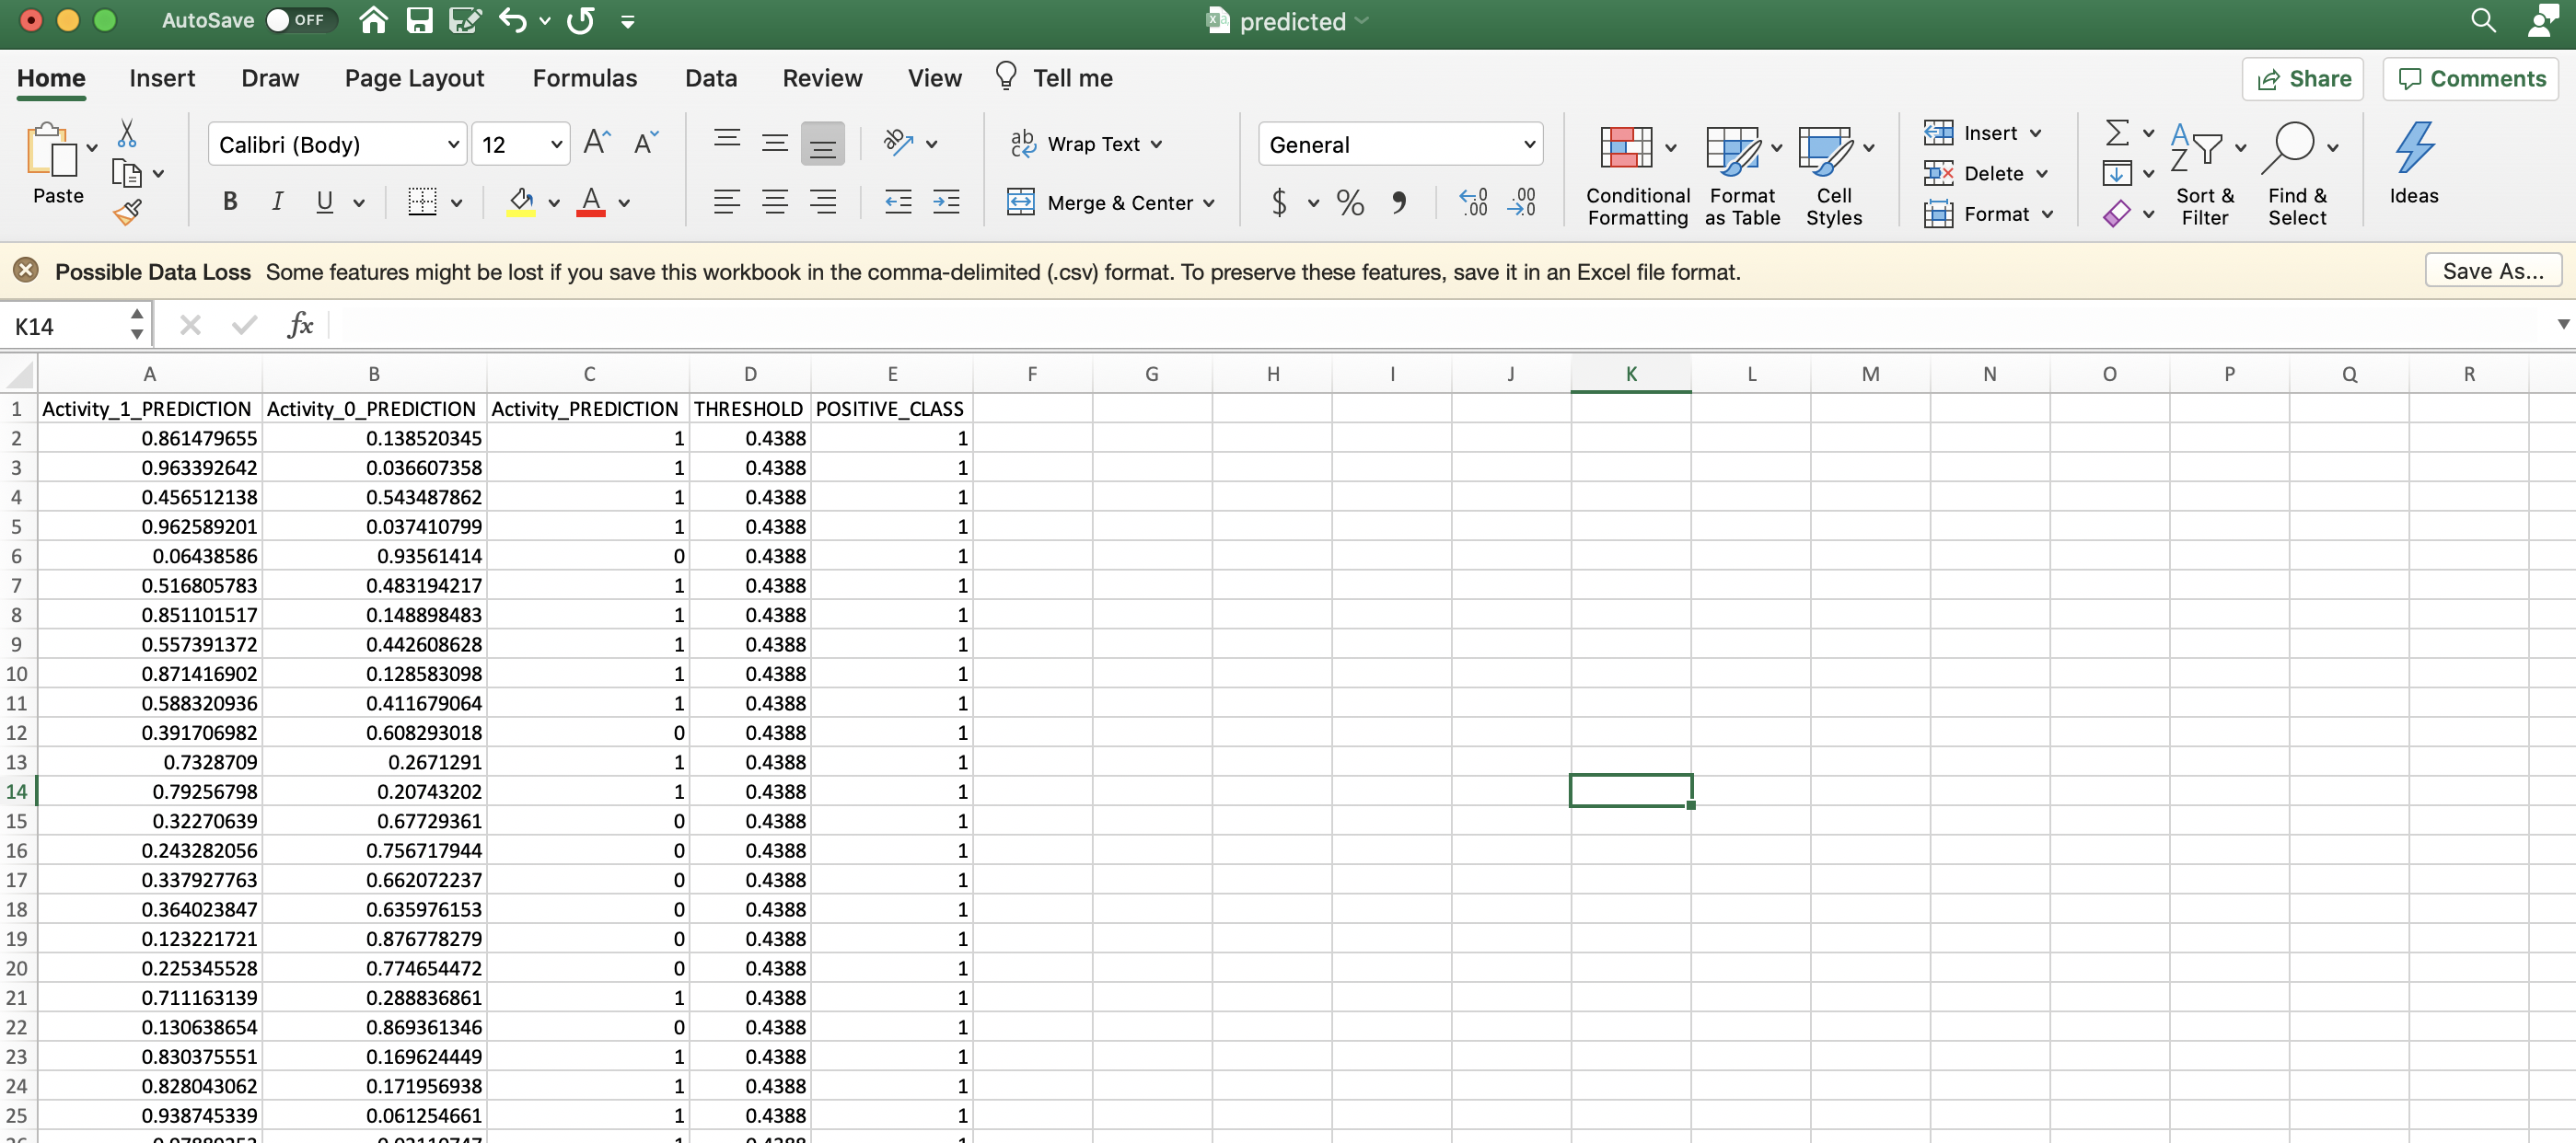

In [9]:
from IPython.display import Image
Image("/predicted.png")

<font size="4"> <b>5. Request Shapley Prediction Explanations</b> </font>

SHAP-based [Prediction Explanations](https://app.datarobot.com/docs/modeling/investigate/understand/pred-explain/index.html) provides an entirely new design in the UI, which you will see further down.
- Compute SHAP-based Prediction Explanations on training data and any external datasets that you have uploaded
- Unlike for XEMP prediction explanations you do not need to have feature impact computed for a model, and predictions for an uploaded dataset


<font size="2"> <b>Top Prediction Explanations</b> </font> <br>
You can get the SHAP explanations by using the <code>Model.request_training_predictions</code> method.
- It's limited to the <code>top 100</code> features

In [10]:
explanations_job = most_accurate_model.request_training_predictions(data_subset = "validationAndHoldout",
                                                                    explanation_algorithm = 'shap',
                                                                    max_explanations = None)

explanations = explanations_job.get_result_when_complete()

explanations_df = explanations.get_all_as_dataframe()

explanations_df.head()

row_id partition_id  prediction  class_1.0  class_0.0  explained_class  \
0       0          0.0         1.0   0.927139   0.072861              1.0   
1       4          0.0         0.0   0.072155   0.927845              1.0   
2       6          0.0         1.0   0.837278   0.162722              1.0   
3       8          0.0         1.0   0.658582   0.341418              1.0   
4      15          0.0         1.0   0.779834   0.220166              1.0   

   shap_remaining_total  shap_base_value Explanation_1_feature_name  \
0              0.121382         0.269053                        D27   
1             -0.061105         0.269053                        D27   
2             -0.022413         0.269053                        D27   
3              0.074258         0.269053                        D27   
4              0.182587         0.269053                        D27   

  Explanation_1_feature_value  ...  Explanation_97_strength  \
0                         1.0  ...                 0.012789   
1                         0.0  ...                -0.011069   
2                         0.0  ...                -0.013667   
3                         1.0  ...                -0.011166   
4                         0.0  ...                -0.013261   

  Explanation_98_feature_name Explanation_98_feature_value  \
0                       D1087                          0.0   
1                         D43                          0.0   
2                        D999                          0.0   
3                       D1052                          0.0   
4                        D973                          1.0   

   Explanation_98_strength Explanation_99_feature_name  \
0                -0.012654                         D85   
1                 0.010715                       D1183   
2                -0.013545                         D69   
3                 0.011073                        D742   
4                -0.013045                        D748   

  Explanation_99_feature_value  Explanation_99_strength  \
0                          0.0                 0.012536   
1                          0.0                -0.010493   
2                       0.0774                 0.013449   
3                          0.0                -0.010884   
4                       0.0625                 0.012842   

  Explanation_100_feature_name Explanation_100_feature_value  \
0                        D1128                           0.0   
1                         D440                           0.0   
2                         D415                           0.0   
3                        D1183                           0.0   
4                          D25                   0.341693036   

   Explanation_100_strength  
0                  0.011738  
1                 -0.010488  
2                  0.013401  
3                 -0.010493  
4                 -0.012738  

[5 rows x 308 columns]

The <code>data_subset</code> variable defines the data set to build predictions on. The value validatonAndHoldout means all data except the training set.<br>
The <code>explanation_algorithm</code> variable defines how the values are calculated. The value shap sets it so the response will include prediction explanations based on the SHAP explainer. <br>
The <code>max_explanations</code> variable defines the maximum number of explanation values that should be returned for each row, ordered by absolute value, greatest to least. The value 100 will return the top 100 explanations.

<font size="2"> <b>SHAP Matrix</b> </font> <br>
You can get the matrix by using the <code>ShapMatrix.create</code> method.
- SHAP matrices are not limited, you can calculate the SHAP values for all the features.

In [11]:
# upload test dataset to generate prediction explanations
dataset = project.upload_dataset(sourcedata = '/bio_response_test_data.csv',
                                 max_wait = 600, 
                                 read_timeout = 600)

# request SHAP matrix calculation
shap_matrix_job = dr.ShapMatrix.create(project.id, most_accurate_model.id, dataset.id)
shap_matrix_job

shap_matrix = shap_matrix_job.get_result_when_complete()
shap_matrix

# list available SHAP matrices
shap_matrices = dr.ShapMatrix.list(project.id)
shap_matrices

shap_matrix = shap_matrices[0]

# get SHAP matrix as dataframe
shap_matrix_values = shap_matrix.get_as_dataframe()
shap_matrix_values

D1        D2   D3   D4        D5        D6        D7        D8  \
0    -0.002087  0.031249  0.0  0.0  0.046115 -0.033463 -0.043934  0.003219   
1    -0.002156  0.015262  0.0  0.0 -0.003022  0.023074  0.000385 -0.007993   
2    -0.001258  0.010910  0.0  0.0  0.007370  0.025066 -0.048074 -0.057742   
3    -0.001472  0.015223  0.0  0.0 -0.011412  0.024033 -0.010699 -0.022347   
4     0.005706  0.001950  0.0  0.0 -0.063003  0.032675  0.008268 -0.079280   
...        ...       ...  ...  ...       ...       ...       ...       ...   
2496 -0.002537  0.007355  0.0  0.0 -0.056925  0.032552 -0.033830 -0.047699   
2497 -0.000235 -0.059818  0.0  0.0 -0.011487 -0.122443 -0.024056 -0.050995   
2498  0.025978 -0.003317  0.0  0.0 -0.008916  0.023462  0.011394  0.006168   
2499  0.014408 -0.016521  0.0  0.0 -0.015680 -0.051574 -0.001494  0.019889   
2500 -0.002214  0.017981  0.0  0.0  0.002802  0.022524 -0.005729  0.008643   

            D9       D10  ...  D1767  D1768  D1769  D1770  D1771  D1772  \
0    -0.042064 -0.088461  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1     0.030870  0.108743  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2     0.033717 -0.010232  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3     0.017415 -0.050203  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4     0.037252 -0.020148  ...    0.0    0.0    0.0    0.0    0.0    0.0   
...        ...       ...  ...    ...    ...    ...    ...    ...    ...   
2496  0.020660 -0.025872  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2497 -0.087056 -0.092360  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2498  0.007581 -0.014015  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2499  0.022904  0.098726  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2500  0.043806  0.048264  ...    0.0    0.0    0.0    0.0    0.0    0.0   

      D1773  D1774  D1775  D1776  
0       0.0    0.0    0.0    0.0  
1       0.0    0.0    0.0    0.0  
2       0.0    0.0    0.0    0.0  
3       0.0    0.0    0.0    0.0  
4       0.0    0.0    0.0    0.0  
...     ...    ...    ...    ...  
2496    0.0    0.0    0.0    0.0  
2497    0.0    0.0    0.0    0.0  
2498    0.0    0.0    0.0    0.0  
2499    0.0    0.0    0.0    0.0  
2500    0.0    0.0    0.0    0.0  

[2501 rows x 1770 columns]

<font size="2"> <b>UI Output</b> </font> <br>
Below is what the prediction explanation download looks like and what the UI looks like.

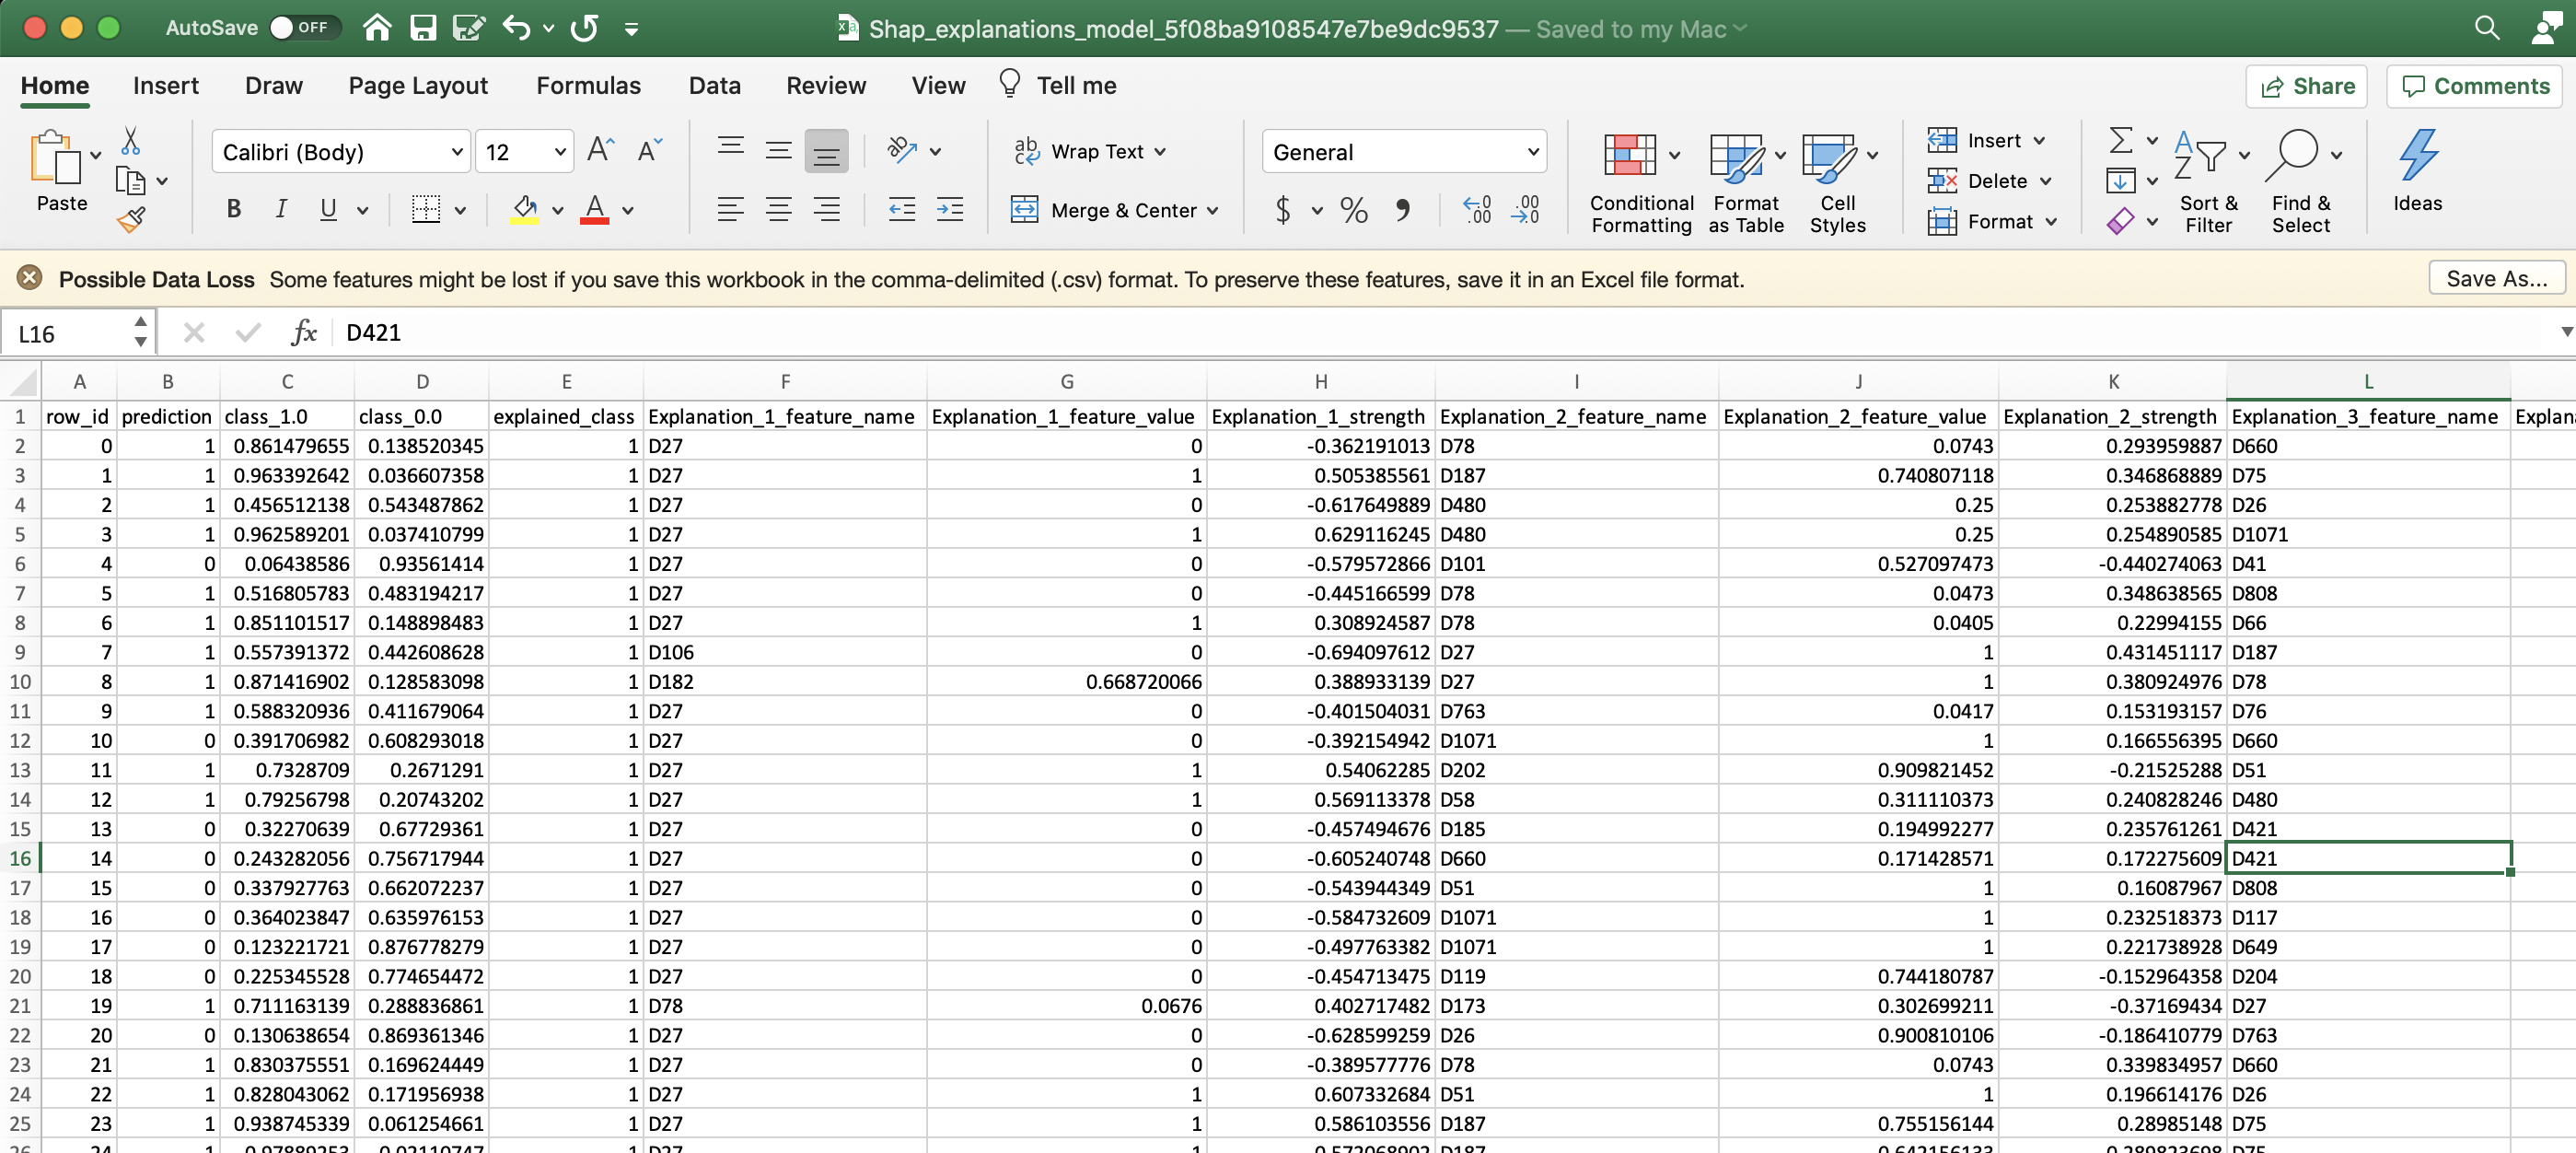

In [12]:
from IPython.display import Image
Image("/SHAP PE.png")

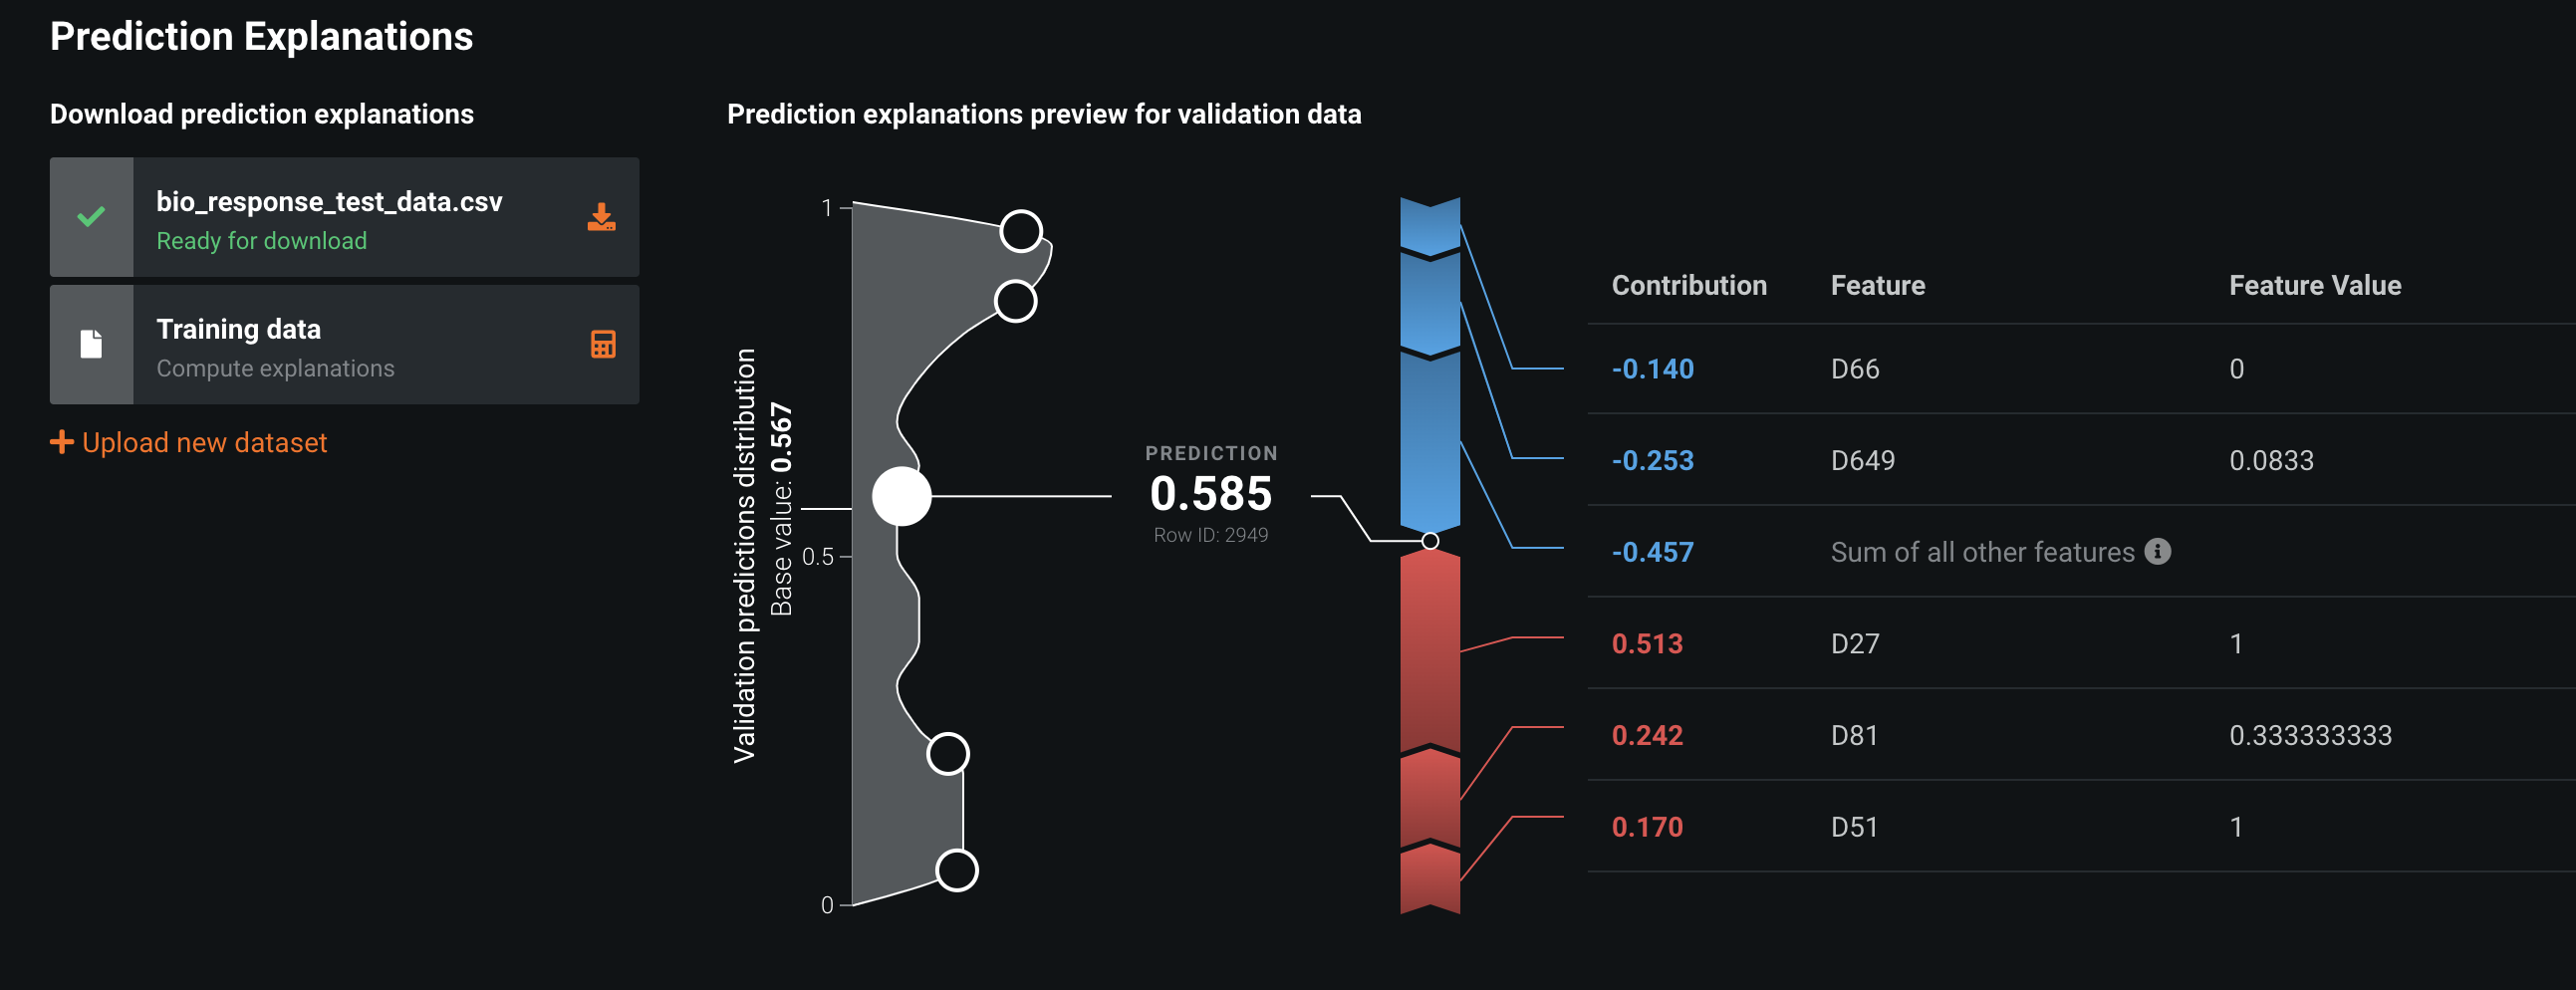

In [13]:
Image("/Desktop/UI PE.png")

<font size="2"> <b>Some notes on interpreting the visualization:</b> </font> <br>

- SHAP is additive which means that the sum of all contributions for all features equals the difference between the base and prediction values.
- Contributions can be either positive or negative.
- Features that push the predictive value to be higher display in red and are positive numbers. Features that reduce the prediction display in blue and are negative numbers.
- The arrows on the plot are proportionate to the SHAP values positively and negatively impacting the observed prediction.
- The “Sum of all other features” is the sum of features that are not part of the top five contributors.

<font size="2"> <b>Why don't the SHAP values add up to the prediction?</b> </font> <br>
The SHAP values are additive in the units of the direct model output. These can be different from the units of prediction for several reasons, which you can read more about [here.](https://app.datarobot.com/docs/reference/shap.html#additivity)
- In this example our blueprint uses a link function so SHAP is additive in a margin space. This means sum(shap) = link(p)-link(p0). The sum of SHAP values, plus the SHAP base value, equals the pre-transformation prediction.

<font size="4"> <b>5. Getting SHAP Output Visualizations</b> </font>

Note that you might have to recreate some of the feature engineering that DataRobot does for us, so the X columns will match the SHAP matrix columns
- For example, date variables might require you to parse the dates and split out to components, and drop some columns the model doesn't use.
- This example does not require that so we will begin with importing shap

In [14]:
import shap
shap.initjs()

In [15]:
# visualize the first prediction's explanation
shap.force_plot(0.567, shap_matrix_values.values[0,:], shap_matrix_values.columns)

The first value is the <code>base_value</code> for the model, constant for the model but will be different if you train to another blueprint or another sample size on the same blueprint.<br>
The second value is the <code>index</code> of the prediction explanation you want to see in your SHAP matrix dataframe.

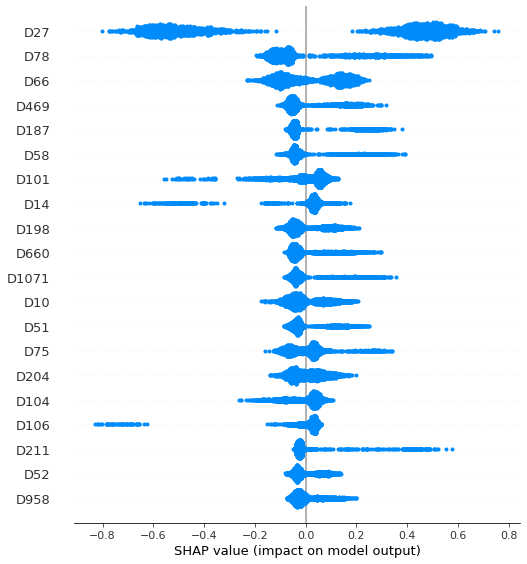

In [16]:
shap.summary_plot(shap_matrix_values.values, shap_matrix_values.columns)

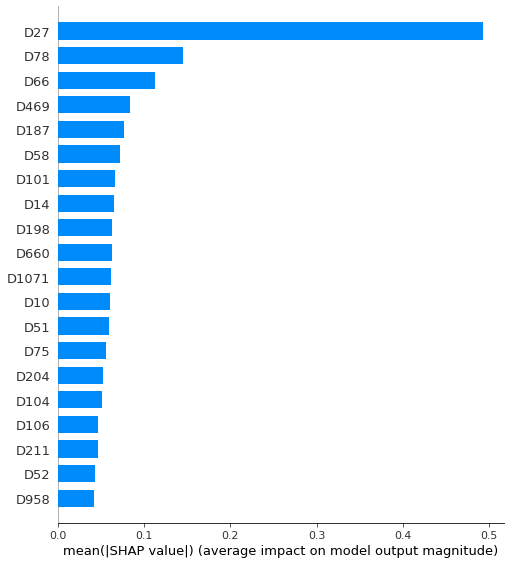

In [17]:
shap.summary_plot(shap_matrix_values.values, shap_matrix_values.columns, plot_type='bar')

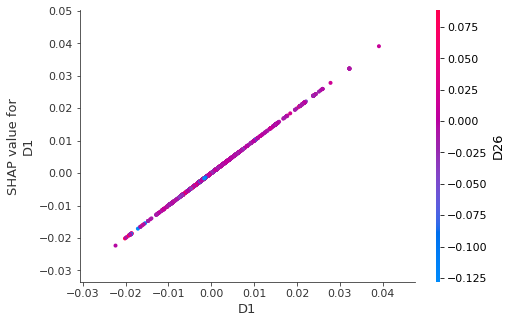

In [18]:
shap.dependence_plot(0, shap_matrix_values.values, shap_matrix_values, interaction_index = 25)

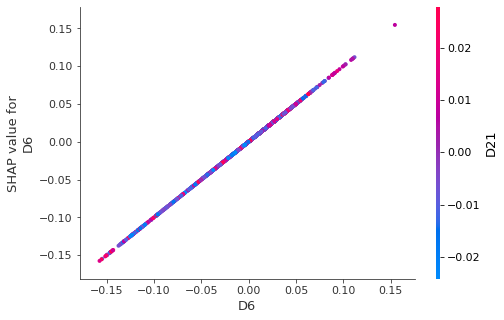

In [19]:
shap.dependence_plot(5, shap_matrix_values.values, shap_matrix_values, interaction_index = 20)

The first argument is the <code>index</code> of the feature we want to plot.<br>
The second argument is the matrix of SHAP values (it is the same shape as the data matrix).<br>
The third argument is the data matrix (a pandas dataframe or numpy array).<br>
The fourth argument is the <code>index</code> of the feature we want to <code>interact</code>.